<a href="https://colab.research.google.com/github/anagha012004/TreeCount/blob/main/TreeCountBhoonidhiVNIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install rasterio opencv-python scikit-image matplotlib numpy


In [3]:
import rasterio
import numpy as np

tif_path = "/content/drive/MyDrive/TreeProj/tree_orchard_count/tree_orchard_count_new0.tif"

with rasterio.open(tif_path) as src:
    red = src.read(3).astype(np.float32)   # Band 3
    nir = src.read(4).astype(np.float32)   # Band 4


In [4]:
print(red.min(), red.max())
print(nir.min(), nir.max())


0.0 423.0
0.0 238.0


In [5]:
ndvi = (nir - red) / (nir + red + 1e-6)


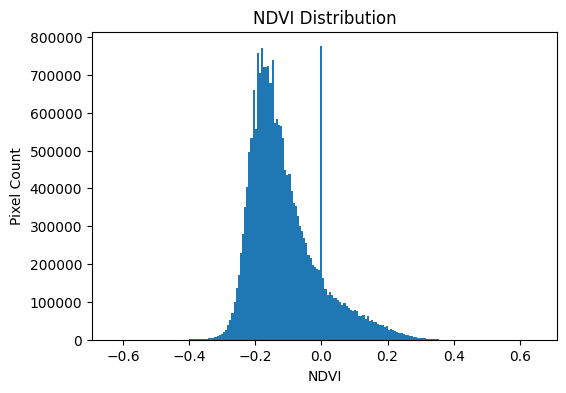

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(ndvi.flatten(), bins=200)
plt.xlabel("NDVI")
plt.ylabel("Pixel Count")
plt.title("NDVI Distribution")
plt.show()


In [11]:
veg_threshold = np.percentile(ndvi, 90)
veg_threshold


np.float32(0.029850746)

In [13]:
tree_mask = ndvi > veg_threshold


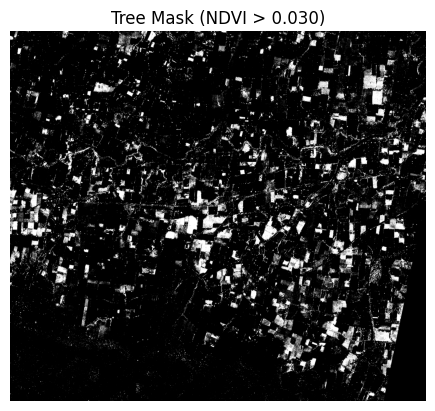

In [14]:
plt.imshow(tree_mask, cmap='gray')
plt.title(f"Tree Mask (NDVI > {veg_threshold:.3f})")
plt.axis("off")
plt.show()


In [9]:
print("NDVI min:", ndvi.min())
print("NDVI max:", ndvi.max())
print("NDVI mean:", ndvi.mean())


NDVI min: -0.6302521
NDVI max: 0.64835167
NDVI mean: -0.11136032


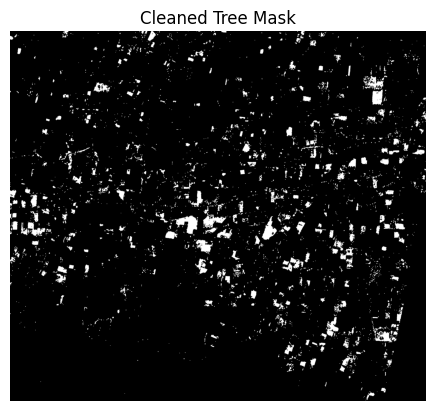

In [15]:
import cv2
import numpy as np

tree_mask_u8 = (tree_mask * 255).astype(np.uint8)
kernel = np.ones((3,3), np.uint8)

clean_mask = cv2.morphologyEx(tree_mask_u8, cv2.MORPH_OPEN, kernel, iterations=2)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(clean_mask, cmap='gray')
plt.title("Cleaned Tree Mask")
plt.axis("off")
plt.show()


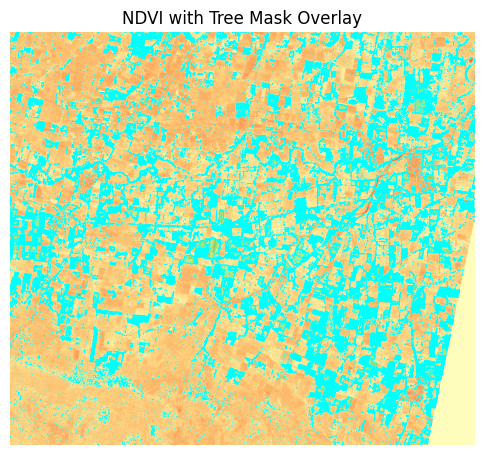

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.contour(tree_mask, colors='cyan', linewidths=0.5)
plt.title("NDVI with Tree Mask Overlay")
plt.axis("off")
plt.show()


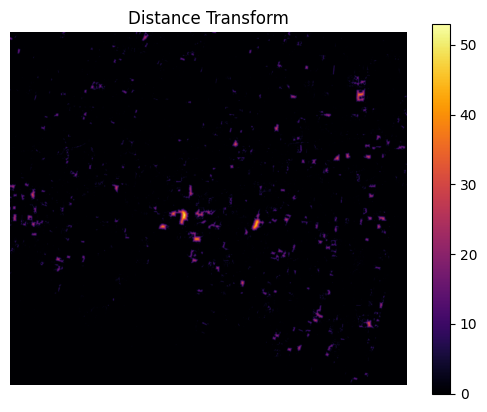

In [17]:
from scipy import ndimage as ndi

distance = ndi.distance_transform_edt(clean_mask)

plt.imshow(distance, cmap='inferno')
plt.title("Distance Transform")
plt.colorbar()
plt.axis("off")
plt.show()


In [18]:
from skimage.feature import peak_local_max

local_max = peak_local_max(
    distance,
    min_distance=6,   # adjust if trees are closer/farther
    labels=clean_mask
)

print("Detected tree centers:", len(local_max))


Detected tree centers: 4988


In [19]:
from skimage.segmentation import watershed

markers = np.zeros_like(distance, dtype=int)
for i, (r, c) in enumerate(local_max):
    markers[r, c] = i + 1

labels = watershed(-distance, markers, mask=clean_mask)


In [20]:
tree_count = len(np.unique(labels)) - 1
print("✅ TOTAL TREE COUNT:", tree_count)


✅ TOTAL TREE COUNT: 4988


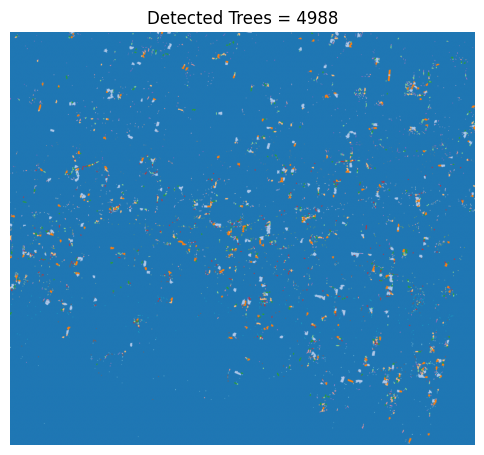

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(labels, cmap='tab20')
plt.title(f"Detected Trees = {tree_count}")
plt.axis("off")
plt.show()
